# ADAPT-Clifford algorithm

This is a notebook with an implementation of the ADAPT-Clifford algorithm for the approximate solution of the MaxCut problem on undirected (un)weighted graphs. In particular we focus on $k$-regular graphs.

In [1]:
### loading some modules
import numpy as np
import matplotlib.pyplot as plt
import stim
import itertools
import networkx as nx

In [2]:
###
#   Some utility functions
###

### Add a layer of Hadamars to the Tableau
def add_H_layer(nbit, c: stim.TableauSimulator):
    """
    This function adds a layer of Hadamar gates to the TableauSimulator
    
    nbit: number of qubits/nodes in the graph
    """
    c.h(*range(nbit))
#

### weight matrix for a complete graph
def weight_matrix_complete(nbit):
    mat = np.zeros((nbit, nbit))
    
    for ii in range(nbit):
        for jj in range(nbit):
            if jj > ii: mat[ii, jj] = np.random.normal(0,1)
        #
    #
    return mat + mat.T
#

### compute the expectation value of the energy
def hamil_terms(nbit, combis, term):
    """
    This function constructs all the ZZ Hamiltonian terms
    
    nbit: number of qubits/nodes 
    combis: a list of tuples (l,m) indicating the edges where the Hamiltonian acts nontrivially  
    term: either X, Y, or Z 
    
    returns a list of the 
    """
    terms = []
    for combi in combis:
        pstring = stim.PauliString(nbit)
        pstring[combi[0]] = term
        pstring[combi[1]] = term
        
        terms.append(pstring)
    #
    return terms
#

def weights_vector(nbit, combis, W):
    """
    For a weighted graph with adjacency matrix W, this function vectorizes W following the ordering of the 
    list of edges given by combis 
    
    nbit: number of qubits/nodes 
    combis: a list of tuples (l,m) indicating the edges where the Hamiltonian acts nontrivially 
    """
    weights = []
    for combi in combis:
        weights.append(W[combi])
    #
    return weights
#

def hamil_expectation_vals(terms, c: stim.TableauSimulator):
    """
    This function computes the expectation value of all of the 
    Hamiltonian terms in the current state
    
    terms: a list with all the Hamiltonian terms, each given by a PauliString
    c: the current state ecoded as a TableauSimulator
    """
    
    vals = []
    for term in terms:
        val = c.peek_observable_expectation(term)
        vals.append(val)
    #
    return vals
#

def current_energy(weights, hterms, c: stim.TableauSimulator):
    """
    This function computes the mean energy of the current state
    
    weights: the vector of edge weights. They follow the same ordering as the edge list
    hterms: the vector of Hamiltonian terms
    """
    expects = hamil_expectation_vals(hterms, c)
    return 0.5*np.dot(weights, expects)
#

In [3]:
### construct one term of the Hamiltonian
def hamiltonian_term(combi, nbit, W):
    """
    This function constructs a 2^nbit vector corresponding to the energy of one of
    the Hamiltonian terms 
    
    combis: A list of tuples representing the edges 
    nbit: the number of qubits/nodes in the graph
    W: the adjacency matrix of the weighted graph
    """
    mat = None
    if nbit-1 == combi[1] and nbit-2 != combi[0]:
        mat = np.kron([1,1], [1,-1])
    elif nbit-2 == combi[1]:
        mat = np.kron([1,-1], [1,1])
    elif nbit-1 == combi[1] and nbit-2 == combi[0]:
        mat = np.kron([1,-1], [1,-1])
    else:
        mat = np.kron([1,1], [1,1])

    for nn in range(nbit-3, -1, -1):
        if nn in combi:
            mat = np.kron([1,-1], mat)
        else:
            mat = np.kron([1,1], mat)
        #
    #
    return 0.5*W[combi]*np.array(mat)
#


### create the full Hamiltonian
def hamil(combis, nbit, W):
    """
    This function returns a vector containing all the energies of the problem Hamiltonian
    
    combis: A list of tuples representing the edges 
    nbit: the number of qubits/nodes in the graph
    W: the adjacency matrix of the weighted graph
    """
    hamil = np.zeros(2**nbit)
    
    for combi in combis:
        hamil = hamil + hamiltonian_term(combi, nbit, W)
    #
    return hamil
#

In [4]:
###
#    Utilty functions to build the gate pool
###

### adding the YZ gate 
def add_YZ_gate(q1, q2, c: stim.TableauSimulator):
    """
    This function applies a e^(pi/4 YZ) gate to the state 
    
    q1: the index of the first qubit 
    q2: the index of the second qubit 
    c: the current state in the form of a TableauSimulator
    """
    
    c.s_dag(q1)
    c.h(q2)
    c.cnot(q1, q2)
    c.z(q1)
    c.h_yz(q1)
    c.cnot(q1, q2)
    c.s(q1)
    c.h(q2)
#

In [8]:
###
#    Utility functions to compute the gradients
###
def gradient(inaqubit, W, aqubits_k, aqubits_j, c: stim.TableauSimulator):
    """
    Given an inactive qubit, this function computes the gradient of it with
    with respect to the two qubits defining the bipartition.
    
    inaqubit: the inactibe qubit under consideration 
    W: a matrix of the edge weights
    aqubits_k: the active qubits which were entangled with qubit k
    aqubits_j: the active qubits which were entangled with qubitt j
    c: the current state encoded as a TableauSimulator
    """
    
    lindex_k = np.intersect1d(np.nonzero(W[:,inaqubit])[0], aqubits_k)
    lindex_j = np.intersect1d(np.nonzero(W[:,inaqubit])[0], aqubits_j)
    
    sum_weights_k = np.sum(W[ll, inaqubit] for ll in lindex_k)
    sum_weights_j = np.sum(W[ll, inaqubit] for ll in lindex_j)
    
    grad_k = -sum_weights_k + sum_weights_j
    return grad_k

#
def pos_max_grad(inaqubits, W, aqubits_k, aqubits_j, c: stim.TableauSimulator):
    """
    This function finds the inactive qubit b with the largest gradient, and the 
    corresponding initial qubit, k or j, with which this largest gradient occurs
    
    inaqubits: the vector of inactive qubits
    W: a matrix of the edge weights
    aqubits_k: the active qubits which were entangled with qubit k
    aqubits_j: the active qubits which were entangled with qubitt j
    c: the current state encoded as a TableauSimulator
    """
    
    all_grads_k = [gradient(inaqubit, W, aqubits_k, aqubits_j, c) for inaqubit in inaqubits]
    all_grads_j = -1.0*np.array(all_grads_k)
    
    pos_max_k = np.argmax(all_grads_k)
    pos_max_j = np.argmax(all_grads_j)
    
    if all_grads_k[pos_max_k] > all_grads_j[pos_max_j]:
        return "k", inaqubits[pos_max_k], all_grads_k[pos_max_k]
    elif all_grads_k[pos_max_k] < all_grads_j[pos_max_j]:
        return "j", inaqubits[pos_max_j], all_grads_j[pos_max_j] 
    else:
        char = np.random.choice([1,2])
        if char == 1:
            return "k", inaqubits[pos_max_k], all_grads_k[pos_max_k]
        elif char == 2:
            return "j", inaqubits[pos_max_j], all_grads_j[pos_max_j]
        #
    #
#

In [1]:
%%time
### system parameters
nbit = 22

### constructing the graph to be solved
degree = 4
G = nx.random_regular_graph(degree, nbit)
W = nx.adjacency_matrix(G)

### getting the pairs (l,m) corresponding to edges of the graph
nzindex = W.nonzero()
nzpairs = [(nzindex[0][ii], nzindex[1][ii]) for ii in range(len(nzindex[1]))]
combis = [combi for combi in itertools.combinations(range(nbit), 2)]

nzcombis = []
for combi in combis: 
    if combi in nzpairs: nzcombis.append(combi)
#

### compute minimum eigenvalue of the problem Hamiltonian
min_ener = np.min(hamil(combis, nbit, W))

### draw the problem graph
nx.draw(G, with_labels = True, edgelist = nzcombis, node_color = "black", 
        node_size = 600, font_color = "white", font_size=18, 
        linewidths = 2.0, pos=nx.kamada_kawai_layout(G))

print("minimum energy is %g" % min_ener)

NameError: name 'nx' is not defined

In [68]:
%%time
### create Hmailtonian terms
wvec = np.ones(len(nzcombis))
Hterms = hamil_terms(nbit, nzcombis, "Z")

### build the initial empty tableau and add the layer of Hadamards
circuit = stim.TableauSimulator()
add_H_layer(nbit, circuit)

### flip the state of qubit at position fqubit
fqubit = 1
circuit.z(fqubit)

### initialize the records of active and inactive qubits
active_qubits_k = []
active_qubits_j = []
inactive_qubits = list(range(nbit))

gate_posis = []
aratio = np.zeros(nbit)
for nn in range(nbit-1):
    ##-- find the combinations corresponding to only the active qubits
    if nn == 0:
        #qpair = np.argmax(W[:,fqubit])
        qpair = np.random.choice(W[:,fqubit].nonzero()[0])
        
        gra = W[qpair,fqubit]
        qubits, grad = (fqubit, qpair), gra
        
        ##-- updating the records of active and inactive qubits
        active_qubits_j.append(qpair)
        active_qubits_k.append(fqubit)
        
        inactive_qubits.remove(qpair)
        inactive_qubits.remove(fqubit)
        
    else:
        aset, qpair, gra = pos_max_grad(inactive_qubits, W, active_qubits_k, active_qubits_j, circuit)
        
        if aset == "k":
            qubits = (qpair, fqubit)
            active_qubits_k.append(qpair)
        elif aset == "j":
            qubits = (qpair, active_qubits_j[0])
            active_qubits_j.append(qpair)
        #
        inactive_qubits.remove(qpair)
    #

    ##-- apply the corresponding gate to the state
    add_YZ_gate(qubits[0], qubits[1], circuit)
    gate_posis.append(qubits)
    
    ener = current_energy(wvec, Hterms, circuit)
    aratio[nn+1] = ener/min_ener
#

print("The approximation ratio is:")
print(aratio[-1])
print("If approximation ratio is not 1, change the initial position and run this cell again!")

The approximation ratio is:
1.0
If approximation ratio is not 1, change the initial position and run this cell again!
CPU times: user 95.4 ms, sys: 1.62 ms, total: 97 ms
Wall time: 96.6 ms


/var/folders/26/yxgjq8h54klbfzczt60j4rvc0000gq/T/ipykernel_7152/1970378083.py:19: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_weights_k = np.sum(W[ll, inaqubit] for ll in lindex_k)
/var/folders/26/yxgjq8h54klbfzczt60j4rvc0000gq/T/ipykernel_7152/1970378083.py:20: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_weights_j = np.sum(W[ll, inaqubit] for ll in lindex_j)


## We can extract the approximated cut from the stabilizer state

In [69]:
sol_string = circuit.measure_many(*range(nbit))
set1, set2 = [], []
for zz in range(nbit):
    if sol_string[zz] == True: set1.append(zz)
    else: set2.append(zz)
#
print("The MaxCut of the graph is")
print((set1, set2))

The MaxCut of the graph is
([0, 2, 3, 5, 7, 9, 11, 14, 18, 19, 21], [1, 4, 6, 8, 10, 12, 13, 15, 16, 17, 20])


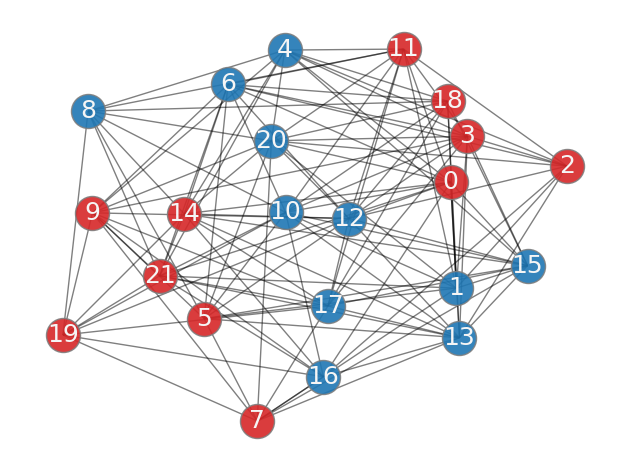

In [70]:
options = {"edgecolors": "tab:gray", "node_size": 600, "alpha": 0.9}
pos = nx.kamada_kawai_layout(G) #, seed=3113794652)
graph_labels = {}
for ii in range(nbit): graph_labels[ii] = str(ii)


nx.draw_networkx_nodes(G, pos, nodelist=set1, node_color="tab:red", **options)
nx.draw_networkx_nodes(G, pos, nodelist=set2, node_color="tab:blue", **options)
nx.draw_networkx_edges(G, pos, edgelist=nzcombis, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, graph_labels, font_size=18, font_color="whitesmoke")
plt.tight_layout()
plt.axis("off")
plt.show()

## Let me look at the approximation ratio!

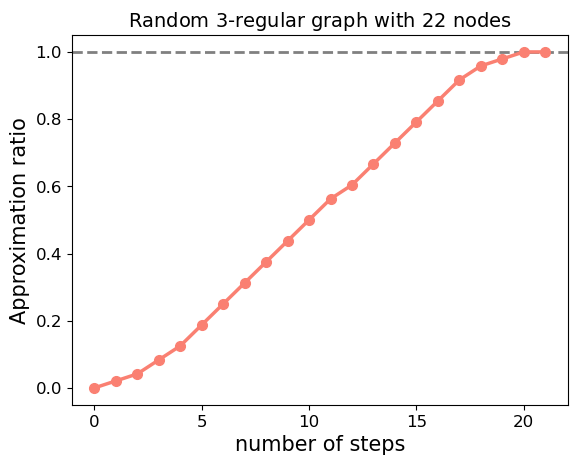

In [71]:
plt.plot(range(nbit), aratio, lw = 2.5, marker = "o", ms = 7, c = "salmon")
plt.xlabel("number of steps", fontsize = 15)
plt.ylabel("Approximation ratio", fontsize = 15)
plt.title("Random $3$-regular graph with %d nodes" % nbit, fontsize = 14)
plt.tick_params(axis = "both", labelsize = 12)
plt.axhline(y=1.0, ls = "--", lw = 2.0, c = "grey", zorder = -1)

plt.show()